In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import snntorch as snn
from snntorch import spikegen
from torch.utils.data import DataLoader
import numpy as np

In [2]:
batch_size  = 80
num_steps   = 5
num_epochs  = 1
lr          = 1e-3
beta        = 0.9
device      = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [70]:
class SimpleCNN(nn.Module):
    def __init__(self, num_steps=20, num_filters=4):
        super(SimpleCNN, self).__init__()
        self.num_steps = num_steps
        self.num_filters = num_filters
        self.conv = nn.Conv2d(in_channels=1, out_channels=self.num_filters, kernel_size=3)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc1 = nn.Linear(self.num_filters * 26 * 26, 256)  # MNIST image size (28x28) reduces to (26x26) after convolution
        self.lif2 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(256, 10)  # MNIST image size (28x28) reduces to (26x26) after convolution
        self.lif3 = snn.Leaky(beta=beta)

    def forward(self, x):
        # x: [B, 1, 28, 28] floats
        spikes = spikegen.rate(x, num_steps=self.num_steps)  # [T, B, 1, 28, 28]
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        spk3_rec = []
        mem3_rec = []

        for t in range(self.num_steps):
            spk1, mem1 = self.lif1(self.conv(spikes[t]), mem1)
            spk1_flat  = spk1.view(x.size(0), -1)
            spk2, mem2 = self.lif2(self.fc1(spk1_flat), mem2)
            spk3, mem3 = self.lif3(self.fc2(spk2), mem3)

            spk3_rec.append(spk3)
            mem3_rec.append(mem3)

        return torch.stack(spk3_rec, dim=0), torch.stack(mem3_rec, dim=0)

cnn_model = SimpleCNN(num_steps=num_steps)


In [19]:
class FullyConnectedEquivalent(nn.Module):
    def __init__(self, cnn_model, num_steps=20, num_filters=4):
        super().__init__()
        self.num_steps = num_steps
        self.num_filters = num_filters
        conv_w = cnn_model.conv.weight.data
        conv_b = cnn_model.conv.bias.data
        self.fc_equiv = nn.Linear(28*28, self.num_filters*26*26)

        with torch.no_grad():
            self.fc_equiv.weight.zero_()
            self.fc_equiv.bias.zero_()

            for oc in range(self.num_filters):
                for ic in range(1):
                    for i in range(26):
                        for j in range(26):
                            neuron_idx = oc*26*26 + i*26 + j
                            for ki in range(3):
                                for kj in range(3):
                                    input_idx = (i+ki)*28 + (j+kj)
                                    self.fc_equiv.weight[neuron_idx, input_idx] = conv_w[oc, ic, ki, kj]
                bias_start = oc*26*26
                bias_end = bias_start + 26*26
                self.fc_equiv.bias[bias_start:bias_end] = conv_b[oc]
        self.lif_equiv = snn.Leaky(beta=beta)
        self.fc_final = cnn_model.fc
        self.lif_final = snn.Leaky(beta=beta)

    def forward(self, x):
        # x: [B, 1, 28, 28] floats
        spikes = spikegen.rate(x, num_steps=self.num_steps)  # [T, B, 1, 28, 28]
        mem1 = self.lif_equiv.init_leaky()
        mem2 = self.lif_final.init_leaky()

        spk2_rec = []
        mem2_rec = []

        for t in range(self.num_steps):

            x = spikes[t].view(x.size(0), -1)
            # print(x.shape)
            out1 = self.fc_equiv(x)
            spk1, mem1 = self.lif_equiv(out1, mem1)
            spk2, mem2 = self.lif_final(self.fc_final(spk1), mem2)

            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)




In [71]:
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))
            ])
train_ds = torchvision.datasets.MNIST(root='../data', train=True, transform=transform, download=True)
test_ds  = torchvision.datasets.MNIST(root='../data', train=False, transform=transform, download=True)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)


In [72]:
conv_model = cnn_model
optimizer  = torch.optim.Adam(conv_model.parameters(), lr=5e-4)
criterion  = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    conv_model.train()
    running_loss = 0.0
    for data, targets in train_loader:
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()
        spk_rec, mem_rec = conv_model(data)      # [T,B,10], [T,B,10]
        # sum loss over timesteps on final-layer membrane
        loss_val = sum(criterion(mem_rec[t], targets) for t in range(num_steps))
        loss_val.backward()
        optimizer.step()
        running_loss += loss_val.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1/1, Loss: 2.3582


In [73]:
conv_model.eval()
correct = total = 0
with torch.no_grad():
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)
        spk_rec, mem_rec = conv_model(data)
        # classify via sum of spikes
        preds = spk_rec.sum(dim=0).argmax(dim=1)
        correct += (preds == targets).sum().item()
        total   += data.size(0)
print(f"ConvSNN Test Accuracy: {100*correct/total:.2f}%")

ConvSNN Test Accuracy: 90.89%


In [23]:

fc_model = FullyConnectedEquivalent(conv_model,num_steps=num_steps)

fc_model.eval()
correct = total = 0
with torch.no_grad():
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)
        spk_rec, mem_rec = fc_model(data)
        preds = spk_rec.sum(dim=0).argmax(dim=1)
        correct += (preds == targets).sum().item()
        total   += data.size(0)
print(f"FCSNN Test Accuracy: {100*correct/total:.2f}%")

FCSNN Test Accuracy: 88.45%


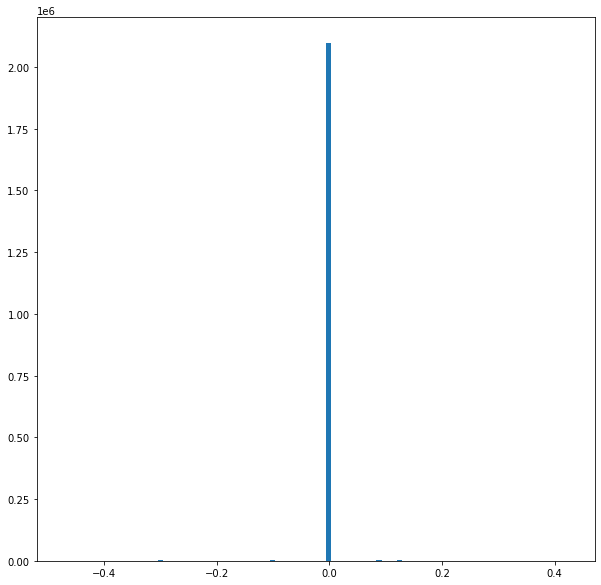

Percentage of weights that are zero: 98.85% of 2119936 weights


In [24]:
import matplotlib.pyplot as plt
import numpy as np

full_weight = fc_model.fc_equiv.weight.data.numpy()
w = full_weight.flatten()

plt.figure(facecolor='white',figsize=(10,10))
plt.hist(w, bins=100)
plt.show()

percentage = float((w == 0).sum() / w.size)
print(f"Percentage of weights that are zero: {percentage:.2%} of {w.size} weights")


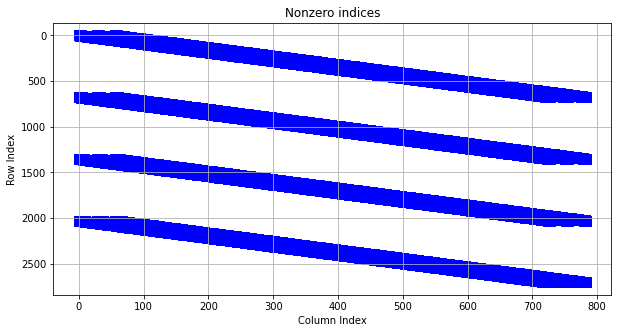

In [25]:
# np.stack(np.nonzero(full_weight))

nonzero_indices = np.nonzero(full_weight)

# Scatter plot of nonzero indices
plt.figure(facecolor='white',figsize=(10,5))
plt.scatter(nonzero_indices[1], nonzero_indices[0], c='blue', marker='s', s=100)

plt.gca().invert_yaxis()  # optional: to match matrix indexing
plt.title("Nonzero indices")
plt.xlabel("Column Index")
plt.ylabel("Row Index")
plt.grid(True)
plt.show()

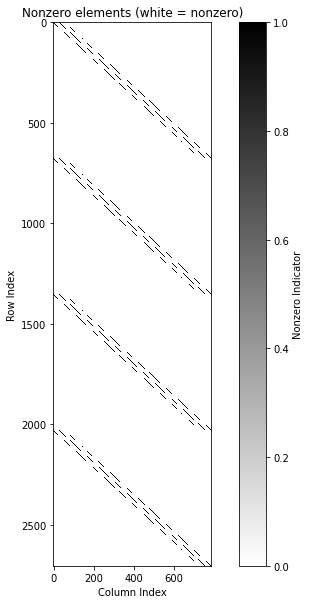

In [26]:
plt.figure(facecolor='white',figsize=(10,10))
plt.imshow(full_weight != 0, cmap='gray_r', interpolation='none')

plt.title("Nonzero elements (white = nonzero)")
plt.xlabel("Column Index")
plt.ylabel("Row Index")
plt.colorbar(label='Nonzero Indicator')
plt.show()

In [27]:
np.nonzero(full_weight[:,3])

(array([   1,    2,    3,  677,  678,  679, 1353, 1354, 1355, 2029, 2030,
        2031]),)

In [74]:
b = conv_model.conv.bias.data
w = conv_model.conv.weight.data
w = w.reshape(4,3,3).reshape(4,9)
fw1 = conv_model.fc1.weight.data.T
fb1 = conv_model.fc1.bias.data
fw2 = conv_model.fc2.weight.data.T
fb2 = conv_model.fc2.bias.data

In [75]:
Q07_SCALE = 128.0
Q07_MAX_FLOAT = 127 / 128.0    # 0.9921875
Q07_MIN_FLOAT = -1.0
Q07_MAX_INT8 = 127
Q07_MIN_INT8 = -128

def quantize_q07(x: float) -> int:
    if x > Q07_MAX_FLOAT:
        x = Q07_MAX_FLOAT
    elif x < Q07_MIN_FLOAT:
        x = Q07_MIN_FLOAT

    scaled = int(x * Q07_SCALE + (0.5 if x >= 0 else -0.5))

    if scaled > Q07_MAX_INT8:
        scaled = Q07_MAX_INT8
    elif scaled < Q07_MIN_INT8:
        scaled = Q07_MIN_INT8

    return np.int8(scaled)

def quantize_tensor_q07(tensor: torch.Tensor):
    tensor_np = tensor.detach().cpu().numpy()
    quantized = np.vectorize(quantize_q07)(tensor_np).astype(np.int8)
    return quantized

In [76]:
qw = quantize_tensor_q07(w)
qb = quantize_tensor_q07(b)
qfw1 = quantize_tensor_q07(fw1)
qfb1 = quantize_tensor_q07(fb1)
qfw2 = quantize_tensor_q07(fw2)
qfb2 = quantize_tensor_q07(fb2)


In [66]:
import numpy as np


out_channels = 4
in_channels = 1
input_height = 28
input_width = 28
output_height = 26
output_width = 26
kh = 3
kw = 3

cnn_weights = conv_model.conv.weight.data.numpy()

output_dim = (output_height, output_width)
input_dim = (input_height, input_width)

sparse_entries = []

for out_ch in range(out_channels):
    for oy in range(output_dim[0]):
        for ox in range(output_dim[1]):
            fc_idx = (out_ch * output_dim[0] * output_dim[1]) + (oy * output_dim[1] + ox)
            for in_ch in range(in_channels):
                for ky in range(kh):
                    for kx in range(kw):
                        iy = oy + ky
                        ix = ox + kx
                        if iy < input_dim[0] and ix < input_dim[1]:
                            input_idx = (in_ch * input_dim[0] * input_dim[1]) + (iy * input_dim[1] + ix)
                            weight = cnn_weights[out_ch, in_ch, ky, kx]
                            if weight != 0:
                                sparse_entries.append((fc_idx, input_idx, quantize_q07(weight), weight))


In [67]:
def format_c_array(var_name: str, array: np.ndarray) -> str:
    shape = array.shape
    dims = ''.join([f"[{d}]" for d in shape])
    result = f"const int8_t {var_name}{dims} = {{\n"

    if array.ndim == 1:
        result += "    { " + ', '.join(str(v) for v in array) + " }\n"
    elif array.ndim == 2:
        for row in array:
            result += "    { " + ', '.join(str(v) for v in row) + " },\n"
    elif array.ndim == 3:
        for mat in array:
            result += "    {\n"
            for row in mat:
                result += "        { " + ', '.join(str(v) for v in row) + " },\n"
            result += "    },\n"
    else:
        raise ValueError(f"Unsupported tensor dimension: {array.ndim}")

    result += "};\n\n"
    return result

In [ ]:
dump_str = format_c_array("conv1_weights_col", qw)
dump_str += format_c_array("conv1_bias", qb)
dump_str += format_c_array("weights_fc1_data", qfw1)
dump_str += format_c_array("bias_fc1", qfb1)
dump_str += format_c_array("weights_fc2_data", qfw2)
dump_str += format_c_array("bias_fc2", qfb2)

with open("dump.c", "w") as f:
    f.write(dump_str)

In [ ]:
with open("dump.c", "w") as f:
    s = qw.shape
    f.write("const int8_t conv1_weights_col[CONV1_KERNEL_FLATTEN][CONV1_FILTERS] = {\n")
    for fc_idx, input_idx, weight_q, weight in sparse_entries:
        f.write(f"    {{{fc_idx}, {input_idx}, {weight_q}, {float(weight)}}},\n")
    f.write("};\n")


NameError: name 'sparse_entries' is not defined

In [44]:
print(conv_model.state_dict())

OrderedDict([('conv.weight', tensor([[[[-0.0016, -0.1494,  0.3126],
          [ 0.3662,  0.3455,  0.4259],
          [-0.0464,  0.2728, -0.1025]]],


        [[[-0.3710, -0.2955, -0.4754],
          [-0.4216, -0.1778, -0.1020],
          [ 0.0551, -0.3602, -0.4400]]],


        [[[ 0.2250,  0.4007,  0.0857],
          [ 0.2097,  0.4162,  0.0952],
          [ 0.1277, -0.0933,  0.1264]]],


        [[[ 0.0065,  0.3796, -0.1395],
          [-0.2134, -0.2986,  0.0903],
          [ 0.3003, -0.1985,  0.2722]]]])), ('conv.bias', tensor([ 0.0042,  0.4111,  0.2288, -0.0071])), ('lif1.threshold', tensor(1.)), ('lif1.graded_spikes_factor', tensor(1.)), ('lif1.reset_mechanism_val', tensor(0)), ('lif1.beta', tensor(0.9000)), ('fc.weight', tensor([[-0.0020, -0.0028, -0.0109,  ...,  0.0089, -0.0053,  0.0018],
        [ 0.0163,  0.0050,  0.0013,  ...,  0.0008, -0.0185, -0.0123],
        [ 0.0060,  0.0027, -0.0062,  ..., -0.0138, -0.0163,  0.0060],
        ...,
        [ 0.0159,  0.0009, -0.0051,  ...,